In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.optim as optim

In [3]:
from Modules import Fingerprint_Generator

fingerprint = "ecfp"

df = pd.read_csv("Transformed_Data/DILIst_DILI.csv", index_col=0)  # Map style dataset
df = Fingerprint_Generator.generate_fp_column(df, df.drug, fp_type=fingerprint)

df_fp = pd.DataFrame(df.iloc[:, 2])
df_fp.insert(len(df_fp.columns), "DILI?", df.iloc[:, 1].astype(int))  # Insert 'DILI?' column as the last column

df_fp.to_csv("Transformed_Data/testo")

[17:11:50] WARNING: not removing hydrogen atom without neighbors
[17:11:50] WARNING: not removing hydrogen atom without neighbors


In [4]:
class DILIDataset(Dataset):
    def __init__(self, features, labels) -> None:
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        features = self.features.iloc[index]
        labels = self.labels.iloc[index]
        return torch.tensor([features], dtype=torch.float32), torch.tensor([labels], dtype=torch.float32)
        # return torch.from_numpy(np.asarray([features])), torch.from_numpy(np.asarray([labels]))


DILIfeatures = df_fp.iloc[:, 0]
DILIlabels = df_fp.iloc[:, 1]

dataset = DILIDataset(DILIfeatures, DILIlabels)

In [5]:
torch.manual_seed(42)

BATCH_SIZE = 12

train_size = int(len(dataset) * 0.8)
validation_size = len(dataset) - train_size

train_data, validation_data = random_split(dataset, [train_size, validation_size])

if len(train_data) + len(validation_data) == len(dataset):
    print("Dataset split succeeded")
else:
    print("Dataset split failed")

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset split succeeded


In [6]:
# Set the device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

Using cuda device: NVIDIA GeForce GTX 1070


In [50]:
class DILI_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        model_output = self.fc1(x)
        model_output = torch.relu(model_output)
        model_output = self.fc2(model_output)
        model_output = torch.relu(model_output)
        model_output = self.fc3(model_output)
        model_output = self.sigmoid(model_output)
        return model_output


model0 = DILI_Predictor(2048, 512, 1).to(device)

In [8]:
from torchmetrics import classification

b_acc = classification.BinaryAccuracy().to(device)
b_auroc = classification.BinaryAUROC(thresholds=None).to(device)


def train_step(model: torch.nn.Module, dataloader: DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_accuracy, train_auroc = 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        predicted_y = model0(X)
        predicted_y = predicted_y.squeeze(1)
        # print(predicted_y.shape); print(y.shape) #  Uncomment to confirm shape

        loss = loss_fn(predicted_y, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy += b_acc(predicted_y, y)
        train_auroc += b_auroc(predicted_y, y)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_accuracy / len(dataloader)
    train_auroc = train_auroc / len(dataloader)
    return train_loss, train_acc, train_auroc

c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [9]:
def test_step(model: torch.nn.Module, dataloader: DataLoader, loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_accuracy, test_auroc = 0, 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_predicted_y = model0(X)
            test_predicted_y = test_predicted_y.squeeze(1)
            # print(test_predicted_y.shape); print(y.shape)#  Uncomment to confirm shape

            loss = loss_fn(test_predicted_y, y)
            test_loss += loss.item()

            test_accuracy += b_acc(test_predicted_y, y)
            test_auroc += b_auroc(test_predicted_y, y)

    # Adjust metrics to get average loss and accuracy per batch
    dataloader_len = len(dataloader)
    test_loss = test_loss / dataloader_len
    test_acc = test_accuracy / dataloader_len
    test_auroc = test_auroc / dataloader_len
    return test_loss, test_acc, test_auroc

In [10]:
DP = 2


def train(model: torch.nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, epochs: int):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_accuracy, train_auroc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_accuracy, test_auroc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | " f"train_loss: {train_loss:.{DP}f} | " f"train_acc: {train_accuracy:.{DP}f} | " f"test_loss: {test_loss:.{DP}f} | " f"test_acc: {test_accuracy:.{DP}f} | train_auroc:{train_auroc:.{DP}f} | test_auroc:{test_auroc:.{DP}f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_accuracy)
        # results["train_auroc"].append(train_auroc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_accuracy)
        # results["test_auroc"].append(test_auroc)

    # 6. Return the filled results at the end of the epochs
    return results

In [51]:
# Define loss function and optimizer
EPOCH_COUNT = 10
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model0.parameters(), lr=0.01)

model0_results = train(model=model0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=EPOCH_COUNT)

Epoch: 1 | train_loss: 0.68 | train_acc: 0.63 | test_loss: 0.57 | test_acc: 0.79 | train_auroc:0.61 | test_auroc:0.87
Epoch: 2 | train_loss: 0.52 | train_acc: 0.77 | test_loss: 0.42 | test_acc: 0.86 | train_auroc:0.82 | test_auroc:0.94
Epoch: 3 | train_loss: 0.33 | train_acc: 0.87 | test_loss: 0.61 | test_acc: 0.75 | train_auroc:0.95 | test_auroc:0.89


c:\Users\Luke\anaconda3\envs\honours\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch: 4 | train_loss: 0.27 | train_acc: 0.90 | test_loss: 0.18 | test_acc: 0.95 | train_auroc:0.96 | test_auroc:0.96
Epoch: 5 | train_loss: 0.17 | train_acc: 0.94 | test_loss: 0.11 | test_acc: 0.95 | train_auroc:0.98 | test_auroc:0.98
Epoch: 6 | train_loss: 0.14 | train_acc: 0.95 | test_loss: 0.08 | test_acc: 0.97 | train_auroc:0.98 | test_auroc:0.99
Epoch: 7 | train_loss: 0.09 | train_acc: 0.97 | test_loss: 0.06 | test_acc: 0.97 | train_auroc:1.00 | test_auroc:1.00
Epoch: 8 | train_loss: 0.08 | train_acc: 0.97 | test_loss: 0.08 | test_acc: 0.98 | train_auroc:1.00 | test_auroc:1.00
Epoch: 9 | train_loss: 0.08 | train_acc: 0.96 | test_loss: 0.04 | test_acc: 0.99 | train_auroc:1.00 | test_auroc:1.00
Epoch: 10 | train_loss: 0.07 | train_acc: 0.98 | test_loss: 0.03 | test_acc: 0.99 | train_auroc:1.00 | test_auroc:1.00


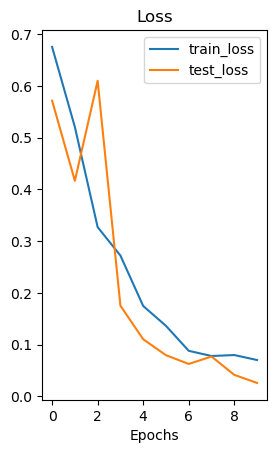

In [52]:
import matplotlib.pyplot as plt


def plot_loss_curve(results: dict[str, list[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curve(model0_results)

In [54]:
from Modules import Save_PyTorch_Models

dummy_data = torch.rand([1, 2048])

dummy_data.shape

Save_PyTorch_Models.save(model0, "DILIst", dummy_data.to(device))

Directory for today's PyTorch models already exists at Pytorch_Models/12-11-2023. Placing saved modles in here.
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [56]:
## Assuming you have loaded_model and device available

from Modules import Fingerprint_Generator

validation_smiles = "Nc1ccc2c(oc3ccccc23)c1"

validation_fp = Fingerprint_Generator.Smiles_To_Fingerprint(validation_smiles, fingerprint).astype(torch.Tensor)
validation_fp = validation_fp.to(device).squeeze(1)
print(validation_fp.shape)

with torch.no_grad():
    model0.eval()
    output = model0(validation_fp)
    prediction = output.item()

print(f"Prediction for {validation_smiles}: {prediction:.4f}")

torch.Size([1, 2048])


RuntimeError: mat1 and mat2 must have the same dtype

from torchmetrics import classification

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 11


b_auroc = classification.BinaryAUROC(thresholds=None)
bcm = classification.BinaryConfusionMatrix()

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model0.train()

    # 1. Forward pass on train data using the forward() method inside
    predicted_labels = model0(train_features)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    train_loss = loss_fn(predicted_labels, train_labels)

    ### Back propagation
    optimizer.zero_grad()  # 3. Zero grad of the optimizer
    train_loss.backward()  # 4. Loss backwards
    optimizer.step()  # 5. Progress the optimizer, update weights

    ### Testing

    # Put the model in evaluation mode
    model0.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model0(train_features)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, train_labels.type(torch.float))  # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 2 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(train_loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())

            # print(test_pred); print(train_labels)
            print(f"Epoch: {epoch} | MAE Train Loss: {train_loss:.3f} | MAE Test Loss: {test_loss:.3f} | AUROC: {b_auroc(test_pred, train_labels)} \n Binary Confusion Matrix: \n {bcm(test_pred, train_labels)} \n {'-'*20} ")

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model0(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model0.train()
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model0.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata
            voutputs = model0(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f"MAE Train Loss: {avg_loss} | MAE Validation Loss: {avg_vloss}")

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model0.state_dict(), model_path)

    epoch_number += 1